In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim
from torch.jit import script, trace
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn import preprocessing

In [2]:
cwd = os.getcwd()

## Load EEG Data

In [4]:
#eeg_s = [
#    np.load("preprocessed_data_Sandra.npy"),
#    np.load("preprocessed_data_Ethan.npy"),
#]

eeg_s = [
    np.load("eeg-data/preprocessed_data_Sandra.npy")
]

In [5]:
def condense_preprocessed_data(eeg_pre):
    return np.array(
        [
            eeg_pre[i, :, j, :]
            for i in range(23)
            for j in range(eeg_pre.shape[2])
            if np.sum(eeg_pre[i, :, j, :]) != 0
        ]
    )


# Combine all sessions into one array
eeg_data = np.vstack([condense_preprocessed_data(session) for session in eeg_s])

print(eeg_data.shape)

(1676, 8, 750)


In [ ]:
def apply_notch_filter(data, fs=250, f0=60, Q=30):
    nyq = 0.5 * fs
    w0 = f0 / nyq
    b, a = signal.iirnotch(w0, Q)
    filtered_data = signal.filtfilt(b, a, data, axis=-1)
    return filtered_data


# Apply the notch filter to the EEG data
eeg_data = apply_notch_filter(eeg_data)

## Load VAD/Emotion Labels

In [6]:
emocsv = pd.read_csv("emotion-data/emotion_data.csv")
emocsv1 = emocsv.iloc[:, 5:]

In [7]:
new_cols = ["How feel", "Pos", "Energ", "Dom", "Content", "Amused", "Angry", "Sad", "Disgust", "Afraid", "Emo"]

In [15]:
emo_labels = pd.DataFrame()

for row in range(2):
    sel_row = emocsv1.iloc[row]
    for i in np.arange(0, emocsv1.shape[1], 11):
        obs = sel_row[i : i + 11].to_frame().T
        obs = obs.rename(columns={obs.columns[i]: new_cols[i] for i in range(11)})
        emo_labels = pd.concat([emo_labels, obs])
print(emo_labels)

                                            How feel Pos Energ Dom Content  \
0  disgusted, but the music made the video funny,...   2     3   7       1   
0                                          disgusted   2     3   7       1   
0                                          disgusted   1     5   7       1   
0                                            relaxed   6     5   8       3   
0                                         moved, sad   3     4   3       1   
0                                                sad   2     5   4       1   
0                                         angry, sad   1     6   3       1   
0                                            neutral   5     3   5       1   
0                                              angry   2     5   4       1   
0                                            annoyed   1     5   2       1   
0              a little bit annoyed, overall neutral   3     5   6       1   
0                                            neutral   5     5  

In [16]:
emo_labels["Pos2"] = emo_labels["Pos"]
emo_labels["Energ2"] = emo_labels["Energ"]
emo_labels["Dom2"] = emo_labels["Dom"]

#emo_labels["Pos2"] = (emo_labels["Pos"] > 4) + 0
#emo_labels["Energ2"] = (emo_labels["Energ"] > 4) + 0
#emo_labels["Dom2"] = (emo_labels["Dom"] > 4) + 0

In [17]:
valence = emo_labels['Pos2'].to_numpy()
arousal = emo_labels['Energ2'].to_numpy()
dominance = emo_labels['Dom2'].to_numpy()

In [18]:
y1, y2, y3 = [], [], []  # VAD labels given for each 3-second data chunk

for session_number, session in enumerate(eeg_s):
    for i in range(23):
        j = 0
        while j < session.shape[2] and np.sum(session[i, :, j, :]) != 0:
            idx = i + session_number * 23
            y1.append(valence[idx])
            y2.append(arousal[idx])
            y3.append(dominance[idx])
            j += 1

print(
    len(y1)
)  # this corresponds to the number of 3-second chunks across all data chunks. 1676 -> ~ 4 minutes per video on average, checks out

1676


In [19]:
y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)

## Create DataLoaders

In [20]:
indices = np.arange(len(eeg_data))
np.random.seed(1)
np.random.shuffle(indices)
indices

array([ 979, 1336,  881, ..., 1096,  235, 1061])

In [21]:
# Define the split ratios
ratios = [0.4, 0.4, 0.2]
train_ratio, valid_ratio, test_ratio = ratios

# Calculate split points
train_end = int(len(indices) * train_ratio)
valid_end = int(len(indices) * (train_ratio + valid_ratio))
test_end = int(len(indices) * (train_ratio + valid_ratio + test_ratio))

# Split the indices
train_indices, valid_indices, test_indices = (
    indices[:train_end],
    indices[train_end:valid_end],
    indices[valid_end:test_end],
)

# Print lengths of each split
print(
    f"Total: {len(indices)}, Train: {len(train_indices)}, Validation: {len(valid_indices)}, Test: {len(test_indices)}"
)

Total: 1676, Train: 670, Validation: 670, Test: 336


In [22]:
x_train = eeg_data[train_indices]
y_train_v = y1[train_indices]
y_train_a = y2[train_indices]
y_train_d = y3[train_indices]

x_valid = eeg_data[valid_indices]
y_valid_v = y1[valid_indices]
y_valid_a = y2[valid_indices]
y_valid_d = y3[valid_indices]

x_test = eeg_data[test_indices]
y_test_v = y1[test_indices]
y_test_a = y2[test_indices]
y_test_d = y3[test_indices]

In [23]:
import torch.utils
import torch.utils.data


train_subset_v = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_v))
val_subset_v = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_v))
test_dataset_v = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_v))

train_subset_a = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_a))
val_subset_a = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_a))
test_dataset_a = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_a))

train_subset_d = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_d))
val_subset_d = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_d))
test_dataset_d = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_d))

bsz = 50

train_loader_v = torch.utils.data.DataLoader(train_subset_v, shuffle=True, batch_size=bsz)
val_loader_v = torch.utils.data.DataLoader(val_subset_v, shuffle=False, batch_size=bsz)
test_loader_v = torch.utils.data.DataLoader(test_dataset_v, shuffle=False, batch_size=bsz)

train_loader_a = torch.utils.data.DataLoader(train_subset_a, shuffle=True, batch_size=bsz)
val_loader_a = torch.utils.data.DataLoader(val_subset_a, shuffle=False, batch_size=bsz)
test_loader_a = torch.utils.data.DataLoader(test_dataset_a, shuffle=False, batch_size=bsz)

train_loader_d = torch.utils.data.DataLoader(train_subset_d, shuffle=True, batch_size=bsz)
val_loader_d = torch.utils.data.DataLoader(val_subset_d, shuffle=False, batch_size=bsz)
test_loader_d = torch.utils.data.DataLoader(test_dataset_d, shuffle=False, batch_size=bsz)

## Neural Network

In [24]:
samp_time = 750
n_channels = 8

In [25]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=40, kernel_size=20, stride=4)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [26]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
v_net = CNN_LSTM()
print(v_net.forward(Variable(input_tensor)))
v_criterion = nn.CrossEntropyLoss() # add to device here
v_optimizer = optim.Adam(v_net.parameters(), lr=0.001, weight_decay=1e-7)

a_net = CNN_LSTM()
a_criterion = nn.CrossEntropyLoss() # add to device here
a_optimizer = optim.Adam(a_net.parameters(), lr=0.001, weight_decay=1e-7)

d_net = CNN_LSTM()
d_criterion = nn.CrossEntropyLoss() # add to device here
d_optimizer = optim.Adam(d_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[0.5573, 0.4427]], grad_fn=<SoftmaxBackward0>)


In [27]:
class CNN_LSTM_Reg(nn.Module):
    def __init__(self):
        super(CNN_LSTM_Reg, self).__init__()
        self.conv1d = nn.Conv1d(
            in_channels=8, out_channels=40, kernel_size=20, stride=4
        )
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400, 1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)

        return x

In [28]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
clr_net = CNN_LSTM_Reg()
print(clr_net.forward(Variable(input_tensor)))
clr_criterion = nn.MSELoss()  # add to device here
clr_optimizer = optim.Adam(d_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[-0.1854]], grad_fn=<AddmmBackward0>)


In [29]:
def train_net(net, optimizer, criterion, train_loader, val_loader, num_epochs):
    train_hist = []
    val_hist = []

    for epoch_idx in tqdm(range(num_epochs)):
        net.train()
        #train_count = 0
        #train_correct_count = 0
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            train_x = train_x.float()
            train_y = train_y.float()
            optimizer.zero_grad()
            op = net(train_x)
            loss = criterion(op, train_y)
            print(loss)
            loss.backward()
            optimizer.step()

            #with torch.no_grad():
            #    y_hat = logits.item()
            #    train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            #    train_count += train_x.size(0)

        #train_acc = train_correct_count / train_count
        #train_hist.append(train_acc)

        net.eval()
        #val_count = 0
        #val_correct_count = 0
        #with torch.no_grad():
        #    for idx, (val_x, val_y) in enumerate(val_loader):
        #        val_x = val_x.float()
        #        val_y = val_y.float()
        #        logits = net(val_x).detach()
        #        y_hat = torch.argmax(logits, dim=-1)
                #val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                #val_count += val_x.size(0)
        #val_acc = val_correct_count / val_count
        #val_hist.append(val_acc)
        #print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

    #plt.plot(train_hist)
    #plt.plot(val_hist)

In [30]:
def eval_net(net, test_loader):
    net.eval()
    test_count = 0
    test_correct_count = 0
    with torch.no_grad():
        for idx, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float()
            test_y = test_y.long()
            logits = net(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)
            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)
    test_acc = test_correct_count / test_count

    print('Test acc: {:.10f}'.format(test_acc))

In [31]:
train_net(clr_net, clr_optimizer, clr_criterion, train_loader_v, val_loader_v, 50)

  0%|          | 0/50 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(23.8624, grad_fn=<MseLossBackward0>)
tensor(23.0628, grad_fn=<MseLossBackward0>)
tensor(29.7708, grad_fn=<MseLossBackward0>)
tensor(19.1854, grad_fn=<MseLossBackward0>)
tensor(24.8513, grad_fn=<MseLossBackward0>)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▏         | 1/50 [00:00<00:23,  2.08it/s]

tensor(26.7106, grad_fn=<MseLossBackward0>)
tensor(19.2397, grad_fn=<MseLossBackward0>)
tensor(26.7006, grad_fn=<MseLossBackward0>)
tensor(25.1191, grad_fn=<MseLossBackward0>)
tensor(22.6864, grad_fn=<MseLossBackward0>)
tensor(20.6115, grad_fn=<MseLossBackward0>)
tensor(28.6894, grad_fn=<MseLossBackward0>)
tensor(25.1014, grad_fn=<MseLossBackward0>)
tensor(33.6800, grad_fn=<MseLossBackward0>)
tensor(31.3126, grad_fn=<MseLossBackward0>)
tensor(25.7259, grad_fn=<MseLossBackward0>)
tensor(27.7439, grad_fn=<MseLossBackward0>)
tensor(23.2529, grad_fn=<MseLossBackward0>)
tensor(22.3030, grad_fn=<MseLossBackward0>)
tensor(23.6705, grad_fn=<MseLossBackward0>)
tensor(24.4227, grad_fn=<MseLossBackward0>)
tensor(24.0569, grad_fn=<MseLossBackward0>)
tensor(21.7211, grad_fn=<MseLossBackward0>)


  4%|▍         | 2/50 [00:00<00:18,  2.57it/s]

tensor(22.9474, grad_fn=<MseLossBackward0>)
tensor(26.5549, grad_fn=<MseLossBackward0>)
tensor(21.0047, grad_fn=<MseLossBackward0>)
tensor(28.0729, grad_fn=<MseLossBackward0>)
tensor(28.6682, grad_fn=<MseLossBackward0>)
tensor(26.7729, grad_fn=<MseLossBackward0>)
tensor(23.5497, grad_fn=<MseLossBackward0>)
tensor(26.7035, grad_fn=<MseLossBackward0>)
tensor(25.2373, grad_fn=<MseLossBackward0>)
tensor(24.4065, grad_fn=<MseLossBackward0>)
tensor(22.4980, grad_fn=<MseLossBackward0>)
tensor(29.7632, grad_fn=<MseLossBackward0>)
tensor(24.7850, grad_fn=<MseLossBackward0>)
tensor(23.7909, grad_fn=<MseLossBackward0>)
tensor(22.4673, grad_fn=<MseLossBackward0>)
tensor(24.0408, grad_fn=<MseLossBackward0>)
tensor(24.2369, grad_fn=<MseLossBackward0>)


  6%|▌         | 3/50 [00:01<00:17,  2.64it/s]

tensor(23.6731, grad_fn=<MseLossBackward0>)
tensor(22.0948, grad_fn=<MseLossBackward0>)
tensor(21.5380, grad_fn=<MseLossBackward0>)
tensor(24.8135, grad_fn=<MseLossBackward0>)
tensor(24.7250, grad_fn=<MseLossBackward0>)
tensor(17.4696, grad_fn=<MseLossBackward0>)
tensor(29.0309, grad_fn=<MseLossBackward0>)
tensor(25.9200, grad_fn=<MseLossBackward0>)
tensor(28.1303, grad_fn=<MseLossBackward0>)


  8%|▊         | 4/50 [00:01<00:16,  2.75it/s]

tensor(23.0883, grad_fn=<MseLossBackward0>)
tensor(21.2001, grad_fn=<MseLossBackward0>)
tensor(24.5490, grad_fn=<MseLossBackward0>)
tensor(25.4489, grad_fn=<MseLossBackward0>)
tensor(28.0442, grad_fn=<MseLossBackward0>)
tensor(28.7359, grad_fn=<MseLossBackward0>)
tensor(21.1613, grad_fn=<MseLossBackward0>)
tensor(25.4606, grad_fn=<MseLossBackward0>)
tensor(27.9494, grad_fn=<MseLossBackward0>)
tensor(25.4474, grad_fn=<MseLossBackward0>)
tensor(20.5252, grad_fn=<MseLossBackward0>)
tensor(23.3221, grad_fn=<MseLossBackward0>)
tensor(24.3450, grad_fn=<MseLossBackward0>)
tensor(24.7540, grad_fn=<MseLossBackward0>)
tensor(24.3102, grad_fn=<MseLossBackward0>)
tensor(25.6131, grad_fn=<MseLossBackward0>)
tensor(24.3651, grad_fn=<MseLossBackward0>)


 10%|█         | 5/50 [00:01<00:16,  2.65it/s]

tensor(23.0985, grad_fn=<MseLossBackward0>)
tensor(26.3970, grad_fn=<MseLossBackward0>)
tensor(26.2620, grad_fn=<MseLossBackward0>)
tensor(20.4453, grad_fn=<MseLossBackward0>)
tensor(19.4182, grad_fn=<MseLossBackward0>)
tensor(24.7348, grad_fn=<MseLossBackward0>)
tensor(25.2516, grad_fn=<MseLossBackward0>)
tensor(24.1036, grad_fn=<MseLossBackward0>)
tensor(21.7454, grad_fn=<MseLossBackward0>)


 12%|█▏        | 6/50 [00:02<00:15,  2.77it/s]

tensor(27.0176, grad_fn=<MseLossBackward0>)
tensor(27.8317, grad_fn=<MseLossBackward0>)
tensor(30.1089, grad_fn=<MseLossBackward0>)
tensor(25.0252, grad_fn=<MseLossBackward0>)
tensor(25.0235, grad_fn=<MseLossBackward0>)
tensor(21.1067, grad_fn=<MseLossBackward0>)
tensor(27.8692, grad_fn=<MseLossBackward0>)
tensor(25.2822, grad_fn=<MseLossBackward0>)
tensor(21.4307, grad_fn=<MseLossBackward0>)
tensor(22.3273, grad_fn=<MseLossBackward0>)
tensor(24.8854, grad_fn=<MseLossBackward0>)
tensor(21.8876, grad_fn=<MseLossBackward0>)
tensor(22.3006, grad_fn=<MseLossBackward0>)
tensor(26.0183, grad_fn=<MseLossBackward0>)
tensor(31.2275, grad_fn=<MseLossBackward0>)
tensor(22.4032, grad_fn=<MseLossBackward0>)
tensor(25.5461, grad_fn=<MseLossBackward0>)
tensor(23.8412, grad_fn=<MseLossBackward0>)


 14%|█▍        | 7/50 [00:02<00:15,  2.82it/s]

tensor(24.5826, grad_fn=<MseLossBackward0>)
tensor(25.3782, grad_fn=<MseLossBackward0>)
tensor(24.6616, grad_fn=<MseLossBackward0>)
tensor(27.5413, grad_fn=<MseLossBackward0>)
tensor(21.1363, grad_fn=<MseLossBackward0>)
tensor(22.1421, grad_fn=<MseLossBackward0>)
tensor(24.3965, grad_fn=<MseLossBackward0>)
tensor(20.0682, grad_fn=<MseLossBackward0>)
tensor(29.4202, grad_fn=<MseLossBackward0>)
tensor(26.7715, grad_fn=<MseLossBackward0>)
tensor(25.4098, grad_fn=<MseLossBackward0>)
tensor(21.6059, grad_fn=<MseLossBackward0>)
tensor(25.4254, grad_fn=<MseLossBackward0>)
tensor(24.0845, grad_fn=<MseLossBackward0>)
tensor(27.3806, grad_fn=<MseLossBackward0>)
tensor(25.7623, grad_fn=<MseLossBackward0>)
tensor(27.5567, grad_fn=<MseLossBackward0>)
tensor(22.5710, grad_fn=<MseLossBackward0>)


 16%|█▌        | 8/50 [00:02<00:14,  2.87it/s]

tensor(20.1347, grad_fn=<MseLossBackward0>)
tensor(27.2878, grad_fn=<MseLossBackward0>)
tensor(25.7262, grad_fn=<MseLossBackward0>)
tensor(25.7192, grad_fn=<MseLossBackward0>)
tensor(24.4660, grad_fn=<MseLossBackward0>)
tensor(21.0515, grad_fn=<MseLossBackward0>)
tensor(24.7464, grad_fn=<MseLossBackward0>)
tensor(27.7109, grad_fn=<MseLossBackward0>)
tensor(22.7206, grad_fn=<MseLossBackward0>)


 18%|█▊        | 9/50 [00:03<00:14,  2.77it/s]

tensor(22.8361, grad_fn=<MseLossBackward0>)
tensor(21.6760, grad_fn=<MseLossBackward0>)
tensor(25.3301, grad_fn=<MseLossBackward0>)
tensor(23.8015, grad_fn=<MseLossBackward0>)
tensor(26.7105, grad_fn=<MseLossBackward0>)
tensor(34.9507, grad_fn=<MseLossBackward0>)
tensor(23.5510, grad_fn=<MseLossBackward0>)
tensor(29.6097, grad_fn=<MseLossBackward0>)
tensor(23.5657, grad_fn=<MseLossBackward0>)
tensor(28.3379, grad_fn=<MseLossBackward0>)
tensor(26.9776, grad_fn=<MseLossBackward0>)
tensor(23.0470, grad_fn=<MseLossBackward0>)
tensor(23.7843, grad_fn=<MseLossBackward0>)
tensor(22.6956, grad_fn=<MseLossBackward0>)
tensor(26.9903, grad_fn=<MseLossBackward0>)
tensor(23.0061, grad_fn=<MseLossBackward0>)


 20%|██        | 10/50 [00:03<00:14,  2.85it/s]

tensor(29.4680, grad_fn=<MseLossBackward0>)
tensor(23.2742, grad_fn=<MseLossBackward0>)
tensor(19.7895, grad_fn=<MseLossBackward0>)
tensor(23.2883, grad_fn=<MseLossBackward0>)
tensor(21.8902, grad_fn=<MseLossBackward0>)
tensor(27.7889, grad_fn=<MseLossBackward0>)
tensor(24.8301, grad_fn=<MseLossBackward0>)
tensor(20.3347, grad_fn=<MseLossBackward0>)
tensor(26.4556, grad_fn=<MseLossBackward0>)
tensor(24.0942, grad_fn=<MseLossBackward0>)
tensor(20.5949, grad_fn=<MseLossBackward0>)
tensor(24.3333, grad_fn=<MseLossBackward0>)
tensor(23.8621, grad_fn=<MseLossBackward0>)
tensor(27.8377, grad_fn=<MseLossBackward0>)
tensor(30.3458, grad_fn=<MseLossBackward0>)
tensor(28.1525, grad_fn=<MseLossBackward0>)
tensor(25.0794, grad_fn=<MseLossBackward0>)


 22%|██▏       | 11/50 [00:03<00:13,  2.84it/s]

tensor(20.2565, grad_fn=<MseLossBackward0>)
tensor(23.9310, grad_fn=<MseLossBackward0>)
tensor(23.0548, grad_fn=<MseLossBackward0>)
tensor(19.5233, grad_fn=<MseLossBackward0>)
tensor(27.9515, grad_fn=<MseLossBackward0>)
tensor(21.5686, grad_fn=<MseLossBackward0>)
tensor(25.0012, grad_fn=<MseLossBackward0>)


 24%|██▍       | 12/50 [00:04<00:13,  2.80it/s]

tensor(26.8656, grad_fn=<MseLossBackward0>)
tensor(22.3626, grad_fn=<MseLossBackward0>)
tensor(23.4898, grad_fn=<MseLossBackward0>)
tensor(25.5195, grad_fn=<MseLossBackward0>)
tensor(25.4790, grad_fn=<MseLossBackward0>)
tensor(29.3878, grad_fn=<MseLossBackward0>)
tensor(23.5843, grad_fn=<MseLossBackward0>)
tensor(23.0852, grad_fn=<MseLossBackward0>)
tensor(24.4545, grad_fn=<MseLossBackward0>)
tensor(24.8296, grad_fn=<MseLossBackward0>)
tensor(26.4145, grad_fn=<MseLossBackward0>)
tensor(22.3149, grad_fn=<MseLossBackward0>)
tensor(23.9231, grad_fn=<MseLossBackward0>)
tensor(29.4560, grad_fn=<MseLossBackward0>)
tensor(27.9456, grad_fn=<MseLossBackward0>)
tensor(24.1991, grad_fn=<MseLossBackward0>)
tensor(24.0070, grad_fn=<MseLossBackward0>)


 26%|██▌       | 13/50 [00:04<00:13,  2.65it/s]

tensor(28.4349, grad_fn=<MseLossBackward0>)
tensor(23.3402, grad_fn=<MseLossBackward0>)
tensor(22.0903, grad_fn=<MseLossBackward0>)
tensor(23.1721, grad_fn=<MseLossBackward0>)
tensor(24.0786, grad_fn=<MseLossBackward0>)
tensor(23.7349, grad_fn=<MseLossBackward0>)
tensor(24.6268, grad_fn=<MseLossBackward0>)
tensor(31.5910, grad_fn=<MseLossBackward0>)
tensor(22.9779, grad_fn=<MseLossBackward0>)
tensor(23.2940, grad_fn=<MseLossBackward0>)
tensor(24.9202, grad_fn=<MseLossBackward0>)
tensor(22.6172, grad_fn=<MseLossBackward0>)
tensor(21.0585, grad_fn=<MseLossBackward0>)
tensor(27.2042, grad_fn=<MseLossBackward0>)
tensor(25.7500, grad_fn=<MseLossBackward0>)
tensor(23.8501, grad_fn=<MseLossBackward0>)
tensor(27.0479, grad_fn=<MseLossBackward0>)
tensor(23.4822, grad_fn=<MseLossBackward0>)


 28%|██▊       | 14/50 [00:05<00:13,  2.72it/s]

tensor(24.8405, grad_fn=<MseLossBackward0>)
tensor(25.0543, grad_fn=<MseLossBackward0>)
tensor(26.6156, grad_fn=<MseLossBackward0>)
tensor(25.0618, grad_fn=<MseLossBackward0>)
tensor(29.8651, grad_fn=<MseLossBackward0>)
tensor(23.1116, grad_fn=<MseLossBackward0>)
tensor(20.5560, grad_fn=<MseLossBackward0>)
tensor(24.6136, grad_fn=<MseLossBackward0>)
tensor(20.0536, grad_fn=<MseLossBackward0>)


 30%|███       | 15/50 [00:05<00:12,  2.78it/s]

tensor(28.6831, grad_fn=<MseLossBackward0>)
tensor(27.2173, grad_fn=<MseLossBackward0>)
tensor(26.3456, grad_fn=<MseLossBackward0>)
tensor(21.5199, grad_fn=<MseLossBackward0>)
tensor(26.6049, grad_fn=<MseLossBackward0>)
tensor(21.3487, grad_fn=<MseLossBackward0>)
tensor(27.7095, grad_fn=<MseLossBackward0>)
tensor(20.0874, grad_fn=<MseLossBackward0>)
tensor(21.2317, grad_fn=<MseLossBackward0>)
tensor(28.4625, grad_fn=<MseLossBackward0>)
tensor(19.8669, grad_fn=<MseLossBackward0>)
tensor(24.2919, grad_fn=<MseLossBackward0>)
tensor(29.9773, grad_fn=<MseLossBackward0>)
tensor(25.7392, grad_fn=<MseLossBackward0>)
tensor(26.6646, grad_fn=<MseLossBackward0>)
tensor(23.7732, grad_fn=<MseLossBackward0>)
tensor(21.3689, grad_fn=<MseLossBackward0>)
tensor(26.6618, grad_fn=<MseLossBackward0>)


 32%|███▏      | 16/50 [00:05<00:12,  2.83it/s]

tensor(21.3845, grad_fn=<MseLossBackward0>)
tensor(30.0302, grad_fn=<MseLossBackward0>)
tensor(25.7766, grad_fn=<MseLossBackward0>)
tensor(23.2404, grad_fn=<MseLossBackward0>)
tensor(28.7800, grad_fn=<MseLossBackward0>)
tensor(24.0179, grad_fn=<MseLossBackward0>)
tensor(23.3172, grad_fn=<MseLossBackward0>)
tensor(25.7508, grad_fn=<MseLossBackward0>)
tensor(22.1693, grad_fn=<MseLossBackward0>)
tensor(23.6506, grad_fn=<MseLossBackward0>)
tensor(24.2072, grad_fn=<MseLossBackward0>)
tensor(27.4347, grad_fn=<MseLossBackward0>)
tensor(25.0361, grad_fn=<MseLossBackward0>)
tensor(23.3156, grad_fn=<MseLossBackward0>)
tensor(23.0615, grad_fn=<MseLossBackward0>)
tensor(20.5751, grad_fn=<MseLossBackward0>)


 34%|███▍      | 17/50 [00:06<00:12,  2.74it/s]

tensor(24.5936, grad_fn=<MseLossBackward0>)
tensor(19.9686, grad_fn=<MseLossBackward0>)
tensor(26.3870, grad_fn=<MseLossBackward0>)
tensor(31.4695, grad_fn=<MseLossBackward0>)
tensor(22.6980, grad_fn=<MseLossBackward0>)
tensor(28.6056, grad_fn=<MseLossBackward0>)
tensor(21.5423, grad_fn=<MseLossBackward0>)
tensor(21.6450, grad_fn=<MseLossBackward0>)
tensor(25.5198, grad_fn=<MseLossBackward0>)


 36%|███▌      | 18/50 [00:06<00:11,  2.82it/s]

tensor(20.4469, grad_fn=<MseLossBackward0>)
tensor(27.8060, grad_fn=<MseLossBackward0>)
tensor(22.7964, grad_fn=<MseLossBackward0>)
tensor(23.9340, grad_fn=<MseLossBackward0>)
tensor(27.8918, grad_fn=<MseLossBackward0>)
tensor(24.6305, grad_fn=<MseLossBackward0>)
tensor(30.7934, grad_fn=<MseLossBackward0>)
tensor(24.4163, grad_fn=<MseLossBackward0>)
tensor(22.1611, grad_fn=<MseLossBackward0>)
tensor(26.7525, grad_fn=<MseLossBackward0>)
tensor(26.0182, grad_fn=<MseLossBackward0>)
tensor(24.7322, grad_fn=<MseLossBackward0>)
tensor(23.9708, grad_fn=<MseLossBackward0>)
tensor(27.3416, grad_fn=<MseLossBackward0>)
tensor(21.0751, grad_fn=<MseLossBackward0>)
tensor(25.7878, grad_fn=<MseLossBackward0>)
tensor(22.9658, grad_fn=<MseLossBackward0>)
tensor(25.1113, grad_fn=<MseLossBackward0>)


 38%|███▊      | 19/50 [00:06<00:10,  2.90it/s]

tensor(16.4363, grad_fn=<MseLossBackward0>)
tensor(21.6393, grad_fn=<MseLossBackward0>)
tensor(25.1643, grad_fn=<MseLossBackward0>)
tensor(24.2879, grad_fn=<MseLossBackward0>)
tensor(26.6914, grad_fn=<MseLossBackward0>)
tensor(20.9420, grad_fn=<MseLossBackward0>)
tensor(24.9572, grad_fn=<MseLossBackward0>)
tensor(23.2816, grad_fn=<MseLossBackward0>)
tensor(24.1522, grad_fn=<MseLossBackward0>)
tensor(25.4342, grad_fn=<MseLossBackward0>)
tensor(22.9096, grad_fn=<MseLossBackward0>)
tensor(27.9489, grad_fn=<MseLossBackward0>)
tensor(26.8088, grad_fn=<MseLossBackward0>)
tensor(24.9490, grad_fn=<MseLossBackward0>)


 40%|████      | 20/50 [00:07<00:11,  2.72it/s]

tensor(26.1655, grad_fn=<MseLossBackward0>)
tensor(23.4452, grad_fn=<MseLossBackward0>)
tensor(24.5035, grad_fn=<MseLossBackward0>)
tensor(23.6995, grad_fn=<MseLossBackward0>)
tensor(23.1352, grad_fn=<MseLossBackward0>)
tensor(19.1752, grad_fn=<MseLossBackward0>)
tensor(20.7950, grad_fn=<MseLossBackward0>)
tensor(29.0954, grad_fn=<MseLossBackward0>)
tensor(25.9342, grad_fn=<MseLossBackward0>)


 42%|████▏     | 21/50 [00:07<00:10,  2.79it/s]

tensor(24.2826, grad_fn=<MseLossBackward0>)
tensor(29.0446, grad_fn=<MseLossBackward0>)
tensor(25.8196, grad_fn=<MseLossBackward0>)
tensor(27.3068, grad_fn=<MseLossBackward0>)
tensor(28.2689, grad_fn=<MseLossBackward0>)
tensor(26.1349, grad_fn=<MseLossBackward0>)
tensor(28.3786, grad_fn=<MseLossBackward0>)
tensor(23.2277, grad_fn=<MseLossBackward0>)
tensor(22.5388, grad_fn=<MseLossBackward0>)
tensor(21.6441, grad_fn=<MseLossBackward0>)
tensor(27.1796, grad_fn=<MseLossBackward0>)
tensor(22.8319, grad_fn=<MseLossBackward0>)
tensor(25.6582, grad_fn=<MseLossBackward0>)
tensor(26.8621, grad_fn=<MseLossBackward0>)
tensor(22.8278, grad_fn=<MseLossBackward0>)
tensor(30.3248, grad_fn=<MseLossBackward0>)
tensor(24.6876, grad_fn=<MseLossBackward0>)


 44%|████▍     | 22/50 [00:07<00:09,  2.85it/s]

tensor(23.9959, grad_fn=<MseLossBackward0>)
tensor(24.8915, grad_fn=<MseLossBackward0>)
tensor(22.9718, grad_fn=<MseLossBackward0>)
tensor(28.2409, grad_fn=<MseLossBackward0>)
tensor(29.3683, grad_fn=<MseLossBackward0>)
tensor(23.6662, grad_fn=<MseLossBackward0>)
tensor(23.0912, grad_fn=<MseLossBackward0>)
tensor(20.8988, grad_fn=<MseLossBackward0>)
tensor(27.6591, grad_fn=<MseLossBackward0>)


 46%|████▌     | 23/50 [00:08<00:09,  2.89it/s]

tensor(26.0287, grad_fn=<MseLossBackward0>)
tensor(23.0164, grad_fn=<MseLossBackward0>)
tensor(21.5260, grad_fn=<MseLossBackward0>)
tensor(27.2652, grad_fn=<MseLossBackward0>)
tensor(26.1924, grad_fn=<MseLossBackward0>)
tensor(24.4517, grad_fn=<MseLossBackward0>)
tensor(24.9693, grad_fn=<MseLossBackward0>)
tensor(22.4842, grad_fn=<MseLossBackward0>)
tensor(17.9584, grad_fn=<MseLossBackward0>)
tensor(23.6194, grad_fn=<MseLossBackward0>)
tensor(25.6594, grad_fn=<MseLossBackward0>)
tensor(28.4112, grad_fn=<MseLossBackward0>)
tensor(24.4100, grad_fn=<MseLossBackward0>)
tensor(24.0344, grad_fn=<MseLossBackward0>)
tensor(20.5718, grad_fn=<MseLossBackward0>)
tensor(31.7696, grad_fn=<MseLossBackward0>)


 48%|████▊     | 24/50 [00:08<00:09,  2.79it/s]

tensor(23.0193, grad_fn=<MseLossBackward0>)
tensor(25.7980, grad_fn=<MseLossBackward0>)
tensor(27.7042, grad_fn=<MseLossBackward0>)
tensor(22.1754, grad_fn=<MseLossBackward0>)
tensor(27.5064, grad_fn=<MseLossBackward0>)
tensor(20.8501, grad_fn=<MseLossBackward0>)
tensor(22.6049, grad_fn=<MseLossBackward0>)
tensor(27.3068, grad_fn=<MseLossBackward0>)
tensor(24.1683, grad_fn=<MseLossBackward0>)
tensor(24.0846, grad_fn=<MseLossBackward0>)
tensor(23.9657, grad_fn=<MseLossBackward0>)
tensor(25.8754, grad_fn=<MseLossBackward0>)
tensor(22.8390, grad_fn=<MseLossBackward0>)
tensor(26.1322, grad_fn=<MseLossBackward0>)
tensor(30.9641, grad_fn=<MseLossBackward0>)
tensor(23.9222, grad_fn=<MseLossBackward0>)
tensor(20.4631, grad_fn=<MseLossBackward0>)
tensor(22.3974, grad_fn=<MseLossBackward0>)
tensor(25.9866, grad_fn=<MseLossBackward0>)


 50%|█████     | 25/50 [00:08<00:08,  2.88it/s]

tensor(20.2391, grad_fn=<MseLossBackward0>)
tensor(28.3612, grad_fn=<MseLossBackward0>)
tensor(26.0974, grad_fn=<MseLossBackward0>)
tensor(22.3707, grad_fn=<MseLossBackward0>)
tensor(26.8428, grad_fn=<MseLossBackward0>)
tensor(27.3559, grad_fn=<MseLossBackward0>)
tensor(26.3621, grad_fn=<MseLossBackward0>)
tensor(22.5023, grad_fn=<MseLossBackward0>)
tensor(26.8265, grad_fn=<MseLossBackward0>)


 52%|█████▏    | 26/50 [00:09<00:08,  2.91it/s]

tensor(23.3076, grad_fn=<MseLossBackward0>)
tensor(21.7662, grad_fn=<MseLossBackward0>)
tensor(26.4718, grad_fn=<MseLossBackward0>)
tensor(24.3687, grad_fn=<MseLossBackward0>)
tensor(24.2364, grad_fn=<MseLossBackward0>)
tensor(20.3177, grad_fn=<MseLossBackward0>)
tensor(23.2200, grad_fn=<MseLossBackward0>)
tensor(23.2319, grad_fn=<MseLossBackward0>)
tensor(27.4307, grad_fn=<MseLossBackward0>)
tensor(26.8728, grad_fn=<MseLossBackward0>)
tensor(22.4492, grad_fn=<MseLossBackward0>)
tensor(28.9767, grad_fn=<MseLossBackward0>)
tensor(22.6609, grad_fn=<MseLossBackward0>)
tensor(20.2835, grad_fn=<MseLossBackward0>)
tensor(20.8677, grad_fn=<MseLossBackward0>)
tensor(24.2984, grad_fn=<MseLossBackward0>)
tensor(28.4420, grad_fn=<MseLossBackward0>)
tensor(26.1482, grad_fn=<MseLossBackward0>)
tensor(26.0169, grad_fn=<MseLossBackward0>)


 54%|█████▍    | 27/50 [00:09<00:07,  2.94it/s]

tensor(21.2572, grad_fn=<MseLossBackward0>)
tensor(30.3674, grad_fn=<MseLossBackward0>)
tensor(22.5167, grad_fn=<MseLossBackward0>)
tensor(27.6107, grad_fn=<MseLossBackward0>)
tensor(23.0973, grad_fn=<MseLossBackward0>)
tensor(23.7201, grad_fn=<MseLossBackward0>)
tensor(20.8759, grad_fn=<MseLossBackward0>)
tensor(25.0842, grad_fn=<MseLossBackward0>)
tensor(27.6711, grad_fn=<MseLossBackward0>)


 56%|█████▌    | 28/50 [00:10<00:07,  2.80it/s]

tensor(23.4641, grad_fn=<MseLossBackward0>)
tensor(21.6112, grad_fn=<MseLossBackward0>)
tensor(27.1482, grad_fn=<MseLossBackward0>)
tensor(23.2442, grad_fn=<MseLossBackward0>)
tensor(24.8324, grad_fn=<MseLossBackward0>)
tensor(22.4866, grad_fn=<MseLossBackward0>)
tensor(21.8574, grad_fn=<MseLossBackward0>)
tensor(24.6608, grad_fn=<MseLossBackward0>)
tensor(19.6424, grad_fn=<MseLossBackward0>)
tensor(21.0111, grad_fn=<MseLossBackward0>)
tensor(24.4987, grad_fn=<MseLossBackward0>)
tensor(31.1255, grad_fn=<MseLossBackward0>)
tensor(27.9566, grad_fn=<MseLossBackward0>)
tensor(21.4626, grad_fn=<MseLossBackward0>)
tensor(25.7746, grad_fn=<MseLossBackward0>)
tensor(27.8601, grad_fn=<MseLossBackward0>)


 58%|█████▊    | 29/50 [00:10<00:07,  2.87it/s]

tensor(24.3674, grad_fn=<MseLossBackward0>)
tensor(28.3018, grad_fn=<MseLossBackward0>)
tensor(24.9577, grad_fn=<MseLossBackward0>)
tensor(23.0356, grad_fn=<MseLossBackward0>)
tensor(31.6807, grad_fn=<MseLossBackward0>)
tensor(25.5121, grad_fn=<MseLossBackward0>)
tensor(24.8976, grad_fn=<MseLossBackward0>)
tensor(21.0067, grad_fn=<MseLossBackward0>)
tensor(27.6917, grad_fn=<MseLossBackward0>)


 60%|██████    | 30/50 [00:10<00:06,  2.88it/s]

tensor(24.2912, grad_fn=<MseLossBackward0>)
tensor(23.6306, grad_fn=<MseLossBackward0>)
tensor(25.2345, grad_fn=<MseLossBackward0>)
tensor(27.0558, grad_fn=<MseLossBackward0>)
tensor(23.9055, grad_fn=<MseLossBackward0>)
tensor(19.6418, grad_fn=<MseLossBackward0>)
tensor(24.4582, grad_fn=<MseLossBackward0>)
tensor(24.4635, grad_fn=<MseLossBackward0>)
tensor(22.9293, grad_fn=<MseLossBackward0>)
tensor(24.4986, grad_fn=<MseLossBackward0>)
tensor(25.9633, grad_fn=<MseLossBackward0>)
tensor(29.2530, grad_fn=<MseLossBackward0>)
tensor(19.9712, grad_fn=<MseLossBackward0>)
tensor(29.7332, grad_fn=<MseLossBackward0>)
tensor(22.6380, grad_fn=<MseLossBackward0>)
tensor(22.2798, grad_fn=<MseLossBackward0>)
tensor(23.7074, grad_fn=<MseLossBackward0>)
tensor(20.6441, grad_fn=<MseLossBackward0>)


 62%|██████▏   | 31/50 [00:11<00:06,  2.94it/s]

tensor(23.2711, grad_fn=<MseLossBackward0>)
tensor(26.5854, grad_fn=<MseLossBackward0>)
tensor(26.5604, grad_fn=<MseLossBackward0>)
tensor(24.1849, grad_fn=<MseLossBackward0>)
tensor(32.4671, grad_fn=<MseLossBackward0>)
tensor(33.0099, grad_fn=<MseLossBackward0>)
tensor(27.8106, grad_fn=<MseLossBackward0>)
tensor(26.4096, grad_fn=<MseLossBackward0>)
tensor(24.5762, grad_fn=<MseLossBackward0>)
tensor(20.3481, grad_fn=<MseLossBackward0>)
tensor(19.0608, grad_fn=<MseLossBackward0>)
tensor(23.8576, grad_fn=<MseLossBackward0>)
tensor(24.2353, grad_fn=<MseLossBackward0>)
tensor(27.7924, grad_fn=<MseLossBackward0>)
tensor(20.0690, grad_fn=<MseLossBackward0>)
tensor(21.5164, grad_fn=<MseLossBackward0>)
tensor(22.9193, grad_fn=<MseLossBackward0>)


 64%|██████▍   | 32/50 [00:11<00:06,  2.84it/s]

tensor(33.0131, grad_fn=<MseLossBackward0>)
tensor(23.5664, grad_fn=<MseLossBackward0>)
tensor(25.1979, grad_fn=<MseLossBackward0>)
tensor(24.3486, grad_fn=<MseLossBackward0>)
tensor(23.3436, grad_fn=<MseLossBackward0>)
tensor(27.6391, grad_fn=<MseLossBackward0>)
tensor(26.1239, grad_fn=<MseLossBackward0>)
tensor(22.8648, grad_fn=<MseLossBackward0>)
tensor(26.3425, grad_fn=<MseLossBackward0>)


 66%|██████▌   | 33/50 [00:11<00:05,  2.90it/s]

tensor(29.7574, grad_fn=<MseLossBackward0>)
tensor(26.4847, grad_fn=<MseLossBackward0>)
tensor(21.5451, grad_fn=<MseLossBackward0>)
tensor(22.9321, grad_fn=<MseLossBackward0>)
tensor(22.9062, grad_fn=<MseLossBackward0>)
tensor(23.8633, grad_fn=<MseLossBackward0>)
tensor(24.9444, grad_fn=<MseLossBackward0>)
tensor(26.0138, grad_fn=<MseLossBackward0>)
tensor(30.0583, grad_fn=<MseLossBackward0>)
tensor(21.8150, grad_fn=<MseLossBackward0>)
tensor(19.5110, grad_fn=<MseLossBackward0>)
tensor(21.5424, grad_fn=<MseLossBackward0>)
tensor(28.1823, grad_fn=<MseLossBackward0>)
tensor(23.2447, grad_fn=<MseLossBackward0>)
tensor(24.6014, grad_fn=<MseLossBackward0>)
tensor(24.8559, grad_fn=<MseLossBackward0>)
tensor(24.6102, grad_fn=<MseLossBackward0>)


 68%|██████▊   | 34/50 [00:12<00:05,  2.91it/s]

tensor(22.1797, grad_fn=<MseLossBackward0>)
tensor(31.3961, grad_fn=<MseLossBackward0>)
tensor(27.0715, grad_fn=<MseLossBackward0>)
tensor(21.6087, grad_fn=<MseLossBackward0>)
tensor(26.0913, grad_fn=<MseLossBackward0>)
tensor(21.7468, grad_fn=<MseLossBackward0>)
tensor(22.5228, grad_fn=<MseLossBackward0>)
tensor(22.7808, grad_fn=<MseLossBackward0>)
tensor(19.1492, grad_fn=<MseLossBackward0>)
tensor(26.1551, grad_fn=<MseLossBackward0>)


 70%|███████   | 35/50 [00:12<00:05,  2.94it/s]

tensor(24.6153, grad_fn=<MseLossBackward0>)
tensor(26.0583, grad_fn=<MseLossBackward0>)
tensor(24.9692, grad_fn=<MseLossBackward0>)
tensor(28.5992, grad_fn=<MseLossBackward0>)
tensor(24.5758, grad_fn=<MseLossBackward0>)
tensor(23.9711, grad_fn=<MseLossBackward0>)
tensor(32.3183, grad_fn=<MseLossBackward0>)
tensor(17.8649, grad_fn=<MseLossBackward0>)
tensor(24.3608, grad_fn=<MseLossBackward0>)
tensor(27.0795, grad_fn=<MseLossBackward0>)
tensor(27.6398, grad_fn=<MseLossBackward0>)
tensor(27.9291, grad_fn=<MseLossBackward0>)
tensor(24.4754, grad_fn=<MseLossBackward0>)
tensor(27.7400, grad_fn=<MseLossBackward0>)
tensor(21.3118, grad_fn=<MseLossBackward0>)
tensor(23.9414, grad_fn=<MseLossBackward0>)


 72%|███████▏  | 36/50 [00:12<00:04,  2.82it/s]

tensor(25.8287, grad_fn=<MseLossBackward0>)
tensor(19.2462, grad_fn=<MseLossBackward0>)
tensor(23.7349, grad_fn=<MseLossBackward0>)
tensor(26.3143, grad_fn=<MseLossBackward0>)
tensor(21.3624, grad_fn=<MseLossBackward0>)
tensor(26.8678, grad_fn=<MseLossBackward0>)
tensor(24.1876, grad_fn=<MseLossBackward0>)
tensor(21.4719, grad_fn=<MseLossBackward0>)
tensor(22.4163, grad_fn=<MseLossBackward0>)
tensor(26.8981, grad_fn=<MseLossBackward0>)
tensor(22.5324, grad_fn=<MseLossBackward0>)
tensor(21.8060, grad_fn=<MseLossBackward0>)
tensor(24.0678, grad_fn=<MseLossBackward0>)
tensor(21.1303, grad_fn=<MseLossBackward0>)
tensor(26.2550, grad_fn=<MseLossBackward0>)
tensor(28.5137, grad_fn=<MseLossBackward0>)
tensor(26.9585, grad_fn=<MseLossBackward0>)
tensor(26.0730, grad_fn=<MseLossBackward0>)


 74%|███████▍  | 37/50 [00:13<00:04,  2.84it/s]

tensor(26.5059, grad_fn=<MseLossBackward0>)
tensor(18.4040, grad_fn=<MseLossBackward0>)
tensor(28.2128, grad_fn=<MseLossBackward0>)
tensor(26.5520, grad_fn=<MseLossBackward0>)
tensor(24.3998, grad_fn=<MseLossBackward0>)
tensor(21.5898, grad_fn=<MseLossBackward0>)
tensor(17.8862, grad_fn=<MseLossBackward0>)
tensor(28.6665, grad_fn=<MseLossBackward0>)
tensor(26.8894, grad_fn=<MseLossBackward0>)
tensor(25.4209, grad_fn=<MseLossBackward0>)


 76%|███████▌  | 38/50 [00:13<00:04,  2.90it/s]

tensor(27.4979, grad_fn=<MseLossBackward0>)
tensor(24.8093, grad_fn=<MseLossBackward0>)
tensor(23.2021, grad_fn=<MseLossBackward0>)
tensor(23.2069, grad_fn=<MseLossBackward0>)
tensor(24.7607, grad_fn=<MseLossBackward0>)
tensor(25.3752, grad_fn=<MseLossBackward0>)
tensor(22.6004, grad_fn=<MseLossBackward0>)
tensor(27.8062, grad_fn=<MseLossBackward0>)
tensor(21.1762, grad_fn=<MseLossBackward0>)
tensor(26.9354, grad_fn=<MseLossBackward0>)
tensor(24.5182, grad_fn=<MseLossBackward0>)
tensor(26.2569, grad_fn=<MseLossBackward0>)
tensor(22.6236, grad_fn=<MseLossBackward0>)
tensor(26.8752, grad_fn=<MseLossBackward0>)
tensor(22.5634, grad_fn=<MseLossBackward0>)
tensor(26.3452, grad_fn=<MseLossBackward0>)
tensor(26.1775, grad_fn=<MseLossBackward0>)
tensor(23.8425, grad_fn=<MseLossBackward0>)


 78%|███████▊  | 39/50 [00:13<00:03,  2.94it/s]

tensor(19.1103, grad_fn=<MseLossBackward0>)
tensor(28.9464, grad_fn=<MseLossBackward0>)
tensor(24.3391, grad_fn=<MseLossBackward0>)
tensor(27.4281, grad_fn=<MseLossBackward0>)
tensor(23.3803, grad_fn=<MseLossBackward0>)
tensor(22.5374, grad_fn=<MseLossBackward0>)
tensor(25.3019, grad_fn=<MseLossBackward0>)
tensor(22.2748, grad_fn=<MseLossBackward0>)
tensor(23.2524, grad_fn=<MseLossBackward0>)
tensor(26.9372, grad_fn=<MseLossBackward0>)
tensor(22.5687, grad_fn=<MseLossBackward0>)
tensor(26.0361, grad_fn=<MseLossBackward0>)
tensor(25.6949, grad_fn=<MseLossBackward0>)
tensor(23.1669, grad_fn=<MseLossBackward0>)
tensor(27.0956, grad_fn=<MseLossBackward0>)
tensor(28.5918, grad_fn=<MseLossBackward0>)


 80%|████████  | 40/50 [00:14<00:03,  2.80it/s]

tensor(25.8421, grad_fn=<MseLossBackward0>)
tensor(29.1624, grad_fn=<MseLossBackward0>)
tensor(23.0789, grad_fn=<MseLossBackward0>)
tensor(31.6196, grad_fn=<MseLossBackward0>)
tensor(23.2038, grad_fn=<MseLossBackward0>)
tensor(28.3467, grad_fn=<MseLossBackward0>)
tensor(22.5141, grad_fn=<MseLossBackward0>)
tensor(25.9960, grad_fn=<MseLossBackward0>)
tensor(21.9584, grad_fn=<MseLossBackward0>)


 82%|████████▏ | 41/50 [00:14<00:03,  2.82it/s]

tensor(23.4707, grad_fn=<MseLossBackward0>)
tensor(24.5351, grad_fn=<MseLossBackward0>)
tensor(24.7328, grad_fn=<MseLossBackward0>)
tensor(24.8714, grad_fn=<MseLossBackward0>)
tensor(16.3465, grad_fn=<MseLossBackward0>)
tensor(28.9232, grad_fn=<MseLossBackward0>)
tensor(26.9018, grad_fn=<MseLossBackward0>)
tensor(22.7242, grad_fn=<MseLossBackward0>)
tensor(22.4967, grad_fn=<MseLossBackward0>)
tensor(24.9483, grad_fn=<MseLossBackward0>)
tensor(26.4023, grad_fn=<MseLossBackward0>)
tensor(19.4655, grad_fn=<MseLossBackward0>)
tensor(25.5091, grad_fn=<MseLossBackward0>)
tensor(23.5209, grad_fn=<MseLossBackward0>)
tensor(27.8907, grad_fn=<MseLossBackward0>)
tensor(24.0822, grad_fn=<MseLossBackward0>)


 84%|████████▍ | 42/50 [00:14<00:02,  2.83it/s]

tensor(27.9219, grad_fn=<MseLossBackward0>)
tensor(24.7488, grad_fn=<MseLossBackward0>)
tensor(17.2672, grad_fn=<MseLossBackward0>)
tensor(25.1882, grad_fn=<MseLossBackward0>)
tensor(20.3473, grad_fn=<MseLossBackward0>)
tensor(23.5056, grad_fn=<MseLossBackward0>)
tensor(23.6100, grad_fn=<MseLossBackward0>)
tensor(19.8285, grad_fn=<MseLossBackward0>)
tensor(26.8294, grad_fn=<MseLossBackward0>)


 86%|████████▌ | 43/50 [00:15<00:02,  2.86it/s]

tensor(20.1850, grad_fn=<MseLossBackward0>)
tensor(26.7797, grad_fn=<MseLossBackward0>)
tensor(24.0296, grad_fn=<MseLossBackward0>)
tensor(31.6195, grad_fn=<MseLossBackward0>)
tensor(23.0533, grad_fn=<MseLossBackward0>)
tensor(24.7880, grad_fn=<MseLossBackward0>)
tensor(28.5516, grad_fn=<MseLossBackward0>)
tensor(29.2431, grad_fn=<MseLossBackward0>)
tensor(24.1722, grad_fn=<MseLossBackward0>)
tensor(23.6091, grad_fn=<MseLossBackward0>)
tensor(24.2513, grad_fn=<MseLossBackward0>)
tensor(29.1299, grad_fn=<MseLossBackward0>)
tensor(23.0359, grad_fn=<MseLossBackward0>)
tensor(24.7682, grad_fn=<MseLossBackward0>)
tensor(23.4366, grad_fn=<MseLossBackward0>)


 88%|████████▊ | 44/50 [00:15<00:02,  2.74it/s]

tensor(23.1809, grad_fn=<MseLossBackward0>)
tensor(24.1041, grad_fn=<MseLossBackward0>)
tensor(22.0294, grad_fn=<MseLossBackward0>)
tensor(27.4370, grad_fn=<MseLossBackward0>)
tensor(24.5705, grad_fn=<MseLossBackward0>)
tensor(24.4178, grad_fn=<MseLossBackward0>)
tensor(25.5554, grad_fn=<MseLossBackward0>)
tensor(22.6620, grad_fn=<MseLossBackward0>)
tensor(29.0541, grad_fn=<MseLossBackward0>)
tensor(24.8806, grad_fn=<MseLossBackward0>)
tensor(26.6038, grad_fn=<MseLossBackward0>)
tensor(26.0737, grad_fn=<MseLossBackward0>)
tensor(25.1140, grad_fn=<MseLossBackward0>)
tensor(24.2683, grad_fn=<MseLossBackward0>)
tensor(27.6028, grad_fn=<MseLossBackward0>)
tensor(20.4913, grad_fn=<MseLossBackward0>)
tensor(21.4794, grad_fn=<MseLossBackward0>)
tensor(21.1116, grad_fn=<MseLossBackward0>)


 90%|█████████ | 45/50 [00:16<00:01,  2.79it/s]

tensor(25.2359, grad_fn=<MseLossBackward0>)
tensor(23.5388, grad_fn=<MseLossBackward0>)
tensor(25.5838, grad_fn=<MseLossBackward0>)
tensor(25.3308, grad_fn=<MseLossBackward0>)
tensor(23.5662, grad_fn=<MseLossBackward0>)
tensor(24.8190, grad_fn=<MseLossBackward0>)
tensor(26.1067, grad_fn=<MseLossBackward0>)
tensor(21.0163, grad_fn=<MseLossBackward0>)
tensor(20.6241, grad_fn=<MseLossBackward0>)


 92%|█████████▏| 46/50 [00:16<00:01,  2.89it/s]

tensor(24.8316, grad_fn=<MseLossBackward0>)
tensor(28.3997, grad_fn=<MseLossBackward0>)
tensor(22.0154, grad_fn=<MseLossBackward0>)
tensor(25.2786, grad_fn=<MseLossBackward0>)
tensor(24.3280, grad_fn=<MseLossBackward0>)
tensor(24.7037, grad_fn=<MseLossBackward0>)
tensor(23.8513, grad_fn=<MseLossBackward0>)
tensor(26.6647, grad_fn=<MseLossBackward0>)
tensor(25.6396, grad_fn=<MseLossBackward0>)
tensor(17.1350, grad_fn=<MseLossBackward0>)
tensor(25.7595, grad_fn=<MseLossBackward0>)
tensor(23.1743, grad_fn=<MseLossBackward0>)
tensor(23.7788, grad_fn=<MseLossBackward0>)
tensor(25.4739, grad_fn=<MseLossBackward0>)
tensor(20.6290, grad_fn=<MseLossBackward0>)
tensor(26.2451, grad_fn=<MseLossBackward0>)
tensor(23.3449, grad_fn=<MseLossBackward0>)
tensor(29.2812, grad_fn=<MseLossBackward0>)
tensor(27.4007, grad_fn=<MseLossBackward0>)


 94%|█████████▍| 47/50 [00:16<00:01,  2.97it/s]

tensor(25.5948, grad_fn=<MseLossBackward0>)
tensor(26.5364, grad_fn=<MseLossBackward0>)
tensor(19.7748, grad_fn=<MseLossBackward0>)
tensor(26.5468, grad_fn=<MseLossBackward0>)
tensor(26.2960, grad_fn=<MseLossBackward0>)
tensor(25.1090, grad_fn=<MseLossBackward0>)
tensor(24.7648, grad_fn=<MseLossBackward0>)
tensor(22.0375, grad_fn=<MseLossBackward0>)
tensor(27.7330, grad_fn=<MseLossBackward0>)
tensor(21.8151, grad_fn=<MseLossBackward0>)
tensor(23.1960, grad_fn=<MseLossBackward0>)
tensor(21.6892, grad_fn=<MseLossBackward0>)
tensor(21.9140, grad_fn=<MseLossBackward0>)
tensor(26.7836, grad_fn=<MseLossBackward0>)
tensor(24.0710, grad_fn=<MseLossBackward0>)


 96%|█████████▌| 48/50 [00:17<00:00,  2.84it/s]

tensor(26.6237, grad_fn=<MseLossBackward0>)
tensor(21.1738, grad_fn=<MseLossBackward0>)
tensor(26.0792, grad_fn=<MseLossBackward0>)
tensor(20.3537, grad_fn=<MseLossBackward0>)
tensor(24.3558, grad_fn=<MseLossBackward0>)
tensor(23.0405, grad_fn=<MseLossBackward0>)
tensor(23.9972, grad_fn=<MseLossBackward0>)
tensor(26.8408, grad_fn=<MseLossBackward0>)
tensor(24.9788, grad_fn=<MseLossBackward0>)


 98%|█████████▊| 49/50 [00:17<00:00,  2.82it/s]

tensor(26.2156, grad_fn=<MseLossBackward0>)
tensor(23.6919, grad_fn=<MseLossBackward0>)
tensor(21.5810, grad_fn=<MseLossBackward0>)
tensor(25.8067, grad_fn=<MseLossBackward0>)
tensor(27.9068, grad_fn=<MseLossBackward0>)
tensor(22.0259, grad_fn=<MseLossBackward0>)
tensor(33.8447, grad_fn=<MseLossBackward0>)
tensor(19.5957, grad_fn=<MseLossBackward0>)
tensor(28.8110, grad_fn=<MseLossBackward0>)
tensor(24.2687, grad_fn=<MseLossBackward0>)
tensor(25.8958, grad_fn=<MseLossBackward0>)
tensor(25.2230, grad_fn=<MseLossBackward0>)
tensor(24.6512, grad_fn=<MseLossBackward0>)
tensor(25.2285, grad_fn=<MseLossBackward0>)
tensor(22.4573, grad_fn=<MseLossBackward0>)
tensor(25.7098, grad_fn=<MseLossBackward0>)
tensor(26.8282, grad_fn=<MseLossBackward0>)


100%|██████████| 50/50 [00:17<00:00,  2.82it/s]

tensor(25.5004, grad_fn=<MseLossBackward0>)
tensor(22.1539, grad_fn=<MseLossBackward0>)
tensor(25.7640, grad_fn=<MseLossBackward0>)
tensor(23.4186, grad_fn=<MseLossBackward0>)


In [32]:
train_net(v_net, v_optimizer, v_criterion, train_loader_v, val_loader_v, 50)

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: expected scalar type Long but found Float

In [33]:
eval_net(v_net, test_loader_v)

Test acc: 0.1696428508


In [34]:
train_net(a_net, a_optimizer, a_criterion, train_loader_a, val_loader_a, 50)

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: expected scalar type Long but found Float

In [ ]:
eval_net(a_net, test_loader_a)

Test acc: 0.8060959578


  4%|▍         | 2/50 [00:00<00:04, 11.22it/s]

Train acc: 0.672, Val acc: 0.716
Train acc: 0.522, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 14%|█▍        | 7/50 [00:00<00:02, 19.08it/s]

Train acc: 0.731, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.701, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 26%|██▌       | 13/50 [00:00<00:01, 22.64it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 38%|███▊      | 19/50 [00:00<00:01, 24.81it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 50%|█████     | 25/50 [00:01<00:00, 25.47it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716


 62%|██████▏   | 31/50 [00:01<00:00, 25.76it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.716, Val acc: 0.716
Train acc: 0.701, Val acc: 0.716
Train acc: 0.731, Val acc: 0.716


 74%|███████▍  | 37/50 [00:01<00:00, 25.79it/s]

Train acc: 0.716, Val acc: 0.716
Train acc: 0.701, Val acc: 0.731
Train acc: 0.731, Val acc: 0.716
Train acc: 0.701, Val acc: 0.716
Train acc: 0.731, Val acc: 0.716
Train acc: 0.761, Val acc: 0.716


 86%|████████▌ | 43/50 [00:01<00:00, 25.93it/s]

Train acc: 0.731, Val acc: 0.716
Train acc: 0.716, Val acc: 0.701
Train acc: 0.701, Val acc: 0.701
Train acc: 0.731, Val acc: 0.701
Train acc: 0.761, Val acc: 0.701
Train acc: 0.746, Val acc: 0.731


 98%|█████████▊| 49/50 [00:02<00:00, 25.64it/s]

Train acc: 0.731, Val acc: 0.761
Train acc: 0.746, Val acc: 0.761
Train acc: 0.806, Val acc: 0.776
Train acc: 0.791, Val acc: 0.776
Train acc: 0.836, Val acc: 0.776


100%|██████████| 50/50 [00:02<00:00, 24.13it/s]

Train acc: 0.761, Val acc: 0.821


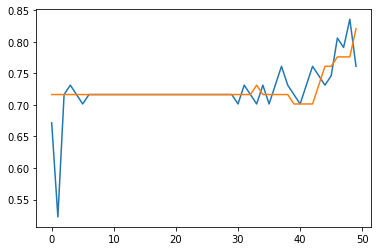

In [ ]:
train_net(d_net, d_optimizer, d_criterion, train_loader_d, val_loader_d, 50)

In [ ]:
eval_net(d_net, test_loader_d)

Test acc: 0.7522698045


## Saving Nets

In [ ]:
torch.save(v_net.state_dict(), cwd + '/vnet')

In [ ]:
torch.save(a_net.state_dict(), cwd + '/anet')

In [ ]:
torch.save(d_net.state_dict(), cwd + 'dnet')

In [ ]:
tester = CNN_LSTM()
tester.load_state_dict(torch.load(cwd + '/vnet'))

<All keys matched successfully>

## Emotions (for later)

In [ ]:
class CNN_LSTM2(nn.Module):
    def __init__(self):
        super(CNN_LSTM2, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=8, out_channels=40, kernel_size=20, stride=4)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(40)
        self.maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.lstm1 = nn.LSTM(input_size=45, hidden_size=30)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batchnorm2 = nn.BatchNorm1d(40)
        self.lstm2 = nn.LSTM(input_size=30, hidden_size=10)
        self.dropout3 = nn.Dropout(p=0.5)
        self.batchnorm3 = nn.BatchNorm1d(40)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(400,6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)

        return x

In [ ]:
input_size = (n_channels, samp_time)

# Random input tensor with the specified dimensions
input_tensor = torch.randn(1, *input_size)
print(input_tensor.shape)

# create neural networks
emo_net = CNN_LSTM2()
print(emo_net.forward(Variable(input_tensor)))
e_criterion = nn.CrossEntropyLoss() # add to device here
e_optimizer = optim.Adam(emo_net.parameters(), lr=0.001, weight_decay=1e-7)

torch.Size([1, 8, 750])
tensor([[0.1739, 0.1834, 0.1254, 0.3558, 0.1200, 0.0415]],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
formal_emotions = emo_labels['Emo']
formal_emotions = formal_emotions.to_numpy()

In [ ]:
formal_emotions = formal_emotions.reshape((formal_emotions.size, 1))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat = OneHotEncoder()
emotions_onehot = cat.fit_transform(formal_emotions).toarray()

In [ ]:
emotion_labels = []
for i in range(23):
    j = 0
    while (j < 211 and np.sum(eeg_s1[i,:,j,:])):
        emotion_labels.append(emotions_onehot[i])
        j += 1
print(len(emotion_labels))

NameError: name 'eeg_s1' is not defined

In [ ]:
emotion_labels = np.array(emotion_labels)

In [ ]:
y_train_e = emotion_labels[train_indices]
y_valid_e = emotion_labels[valid_indices]
y_test_e = emotion_labels[test_indices]

In [ ]:
train_subset_e = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train_e))
val_subset_e = torch.utils.data.TensorDataset(torch.Tensor(x_valid), torch.Tensor(y_valid_e))
test_dataset_e = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test_e))

train_loader_e = torch.utils.data.DataLoader(train_subset_v, shuffle=True, batch_size=bsz)
val_loader_e = torch.utils.data.DataLoader(val_subset_v, shuffle=False, batch_size=bsz)
test_loader_e = torch.utils.data.DataLoader(test_dataset_v, shuffle=False, batch_size=bsz)

  2%|▏         | 1/50 [00:01<01:33,  1.91s/it]

Train acc: 0.521, Val acc: 0.693


  4%|▍         | 2/50 [00:03<01:28,  1.84s/it]

Train acc: 0.754, Val acc: 0.823


  6%|▌         | 3/50 [00:05<01:22,  1.75s/it]

Train acc: 0.878, Val acc: 0.849


  8%|▊         | 4/50 [00:06<01:17,  1.69s/it]

Train acc: 0.946, Val acc: 0.903


 10%|█         | 5/50 [00:08<01:15,  1.68s/it]

Train acc: 0.984, Val acc: 0.981


 12%|█▏        | 6/50 [00:10<01:13,  1.66s/it]

Train acc: 0.999, Val acc: 0.973


 14%|█▍        | 7/50 [00:11<01:10,  1.64s/it]

Train acc: 0.999, Val acc: 0.994


 16%|█▌        | 8/50 [00:13<01:09,  1.66s/it]

Train acc: 1.000, Val acc: 0.997


 18%|█▊        | 9/50 [00:15<01:08,  1.67s/it]

Train acc: 1.000, Val acc: 0.996


 20%|██        | 10/50 [00:16<01:07,  1.68s/it]

Train acc: 1.000, Val acc: 0.981


 22%|██▏       | 11/50 [00:18<01:04,  1.66s/it]

Train acc: 1.000, Val acc: 0.997


 24%|██▍       | 12/50 [00:20<01:02,  1.65s/it]

Train acc: 1.000, Val acc: 1.000


 26%|██▌       | 13/50 [00:21<01:00,  1.62s/it]

Train acc: 1.000, Val acc: 0.994


 28%|██▊       | 14/50 [00:24<01:06,  1.84s/it]

Train acc: 1.000, Val acc: 1.000


 30%|███       | 15/50 [00:26<01:05,  1.88s/it]

Train acc: 1.000, Val acc: 1.000


 32%|███▏      | 16/50 [00:27<01:03,  1.87s/it]

Train acc: 1.000, Val acc: 0.997


 34%|███▍      | 17/50 [00:29<00:59,  1.80s/it]

Train acc: 1.000, Val acc: 1.000


 36%|███▌      | 18/50 [00:31<00:56,  1.76s/it]

Train acc: 1.000, Val acc: 1.000


 38%|███▊      | 19/50 [00:32<00:53,  1.74s/it]

Train acc: 1.000, Val acc: 0.997


 40%|████      | 20/50 [00:34<00:50,  1.69s/it]

Train acc: 1.000, Val acc: 0.997


 42%|████▏     | 21/50 [00:35<00:47,  1.64s/it]

Train acc: 1.000, Val acc: 0.993


 44%|████▍     | 22/50 [00:37<00:45,  1.63s/it]

Train acc: 1.000, Val acc: 0.981


 46%|████▌     | 23/50 [00:39<00:44,  1.64s/it]

Train acc: 1.000, Val acc: 0.988


 48%|████▊     | 24/50 [00:40<00:41,  1.58s/it]

Train acc: 1.000, Val acc: 0.999


 50%|█████     | 25/50 [00:42<00:39,  1.58s/it]

Train acc: 1.000, Val acc: 0.999


 52%|█████▏    | 26/50 [00:43<00:38,  1.59s/it]

Train acc: 1.000, Val acc: 0.997


 54%|█████▍    | 27/50 [00:45<00:37,  1.62s/it]

Train acc: 1.000, Val acc: 1.000


 56%|█████▌    | 28/50 [00:47<00:35,  1.61s/it]

Train acc: 1.000, Val acc: 0.997


 58%|█████▊    | 29/50 [00:48<00:34,  1.66s/it]

Train acc: 1.000, Val acc: 1.000


 60%|██████    | 30/50 [00:50<00:33,  1.68s/it]

Train acc: 1.000, Val acc: 0.997


 62%|██████▏   | 31/50 [00:53<00:38,  2.03s/it]

Train acc: 1.000, Val acc: 1.000


 64%|██████▍   | 32/50 [00:56<00:40,  2.23s/it]

Train acc: 1.000, Val acc: 0.997


 66%|██████▌   | 33/50 [00:57<00:35,  2.08s/it]

Train acc: 1.000, Val acc: 1.000


 68%|██████▊   | 34/50 [00:59<00:31,  1.95s/it]

Train acc: 1.000, Val acc: 1.000


 70%|███████   | 35/50 [01:01<00:27,  1.86s/it]

Train acc: 1.000, Val acc: 0.997


 72%|███████▏  | 36/50 [01:02<00:25,  1.82s/it]

Train acc: 1.000, Val acc: 1.000


 74%|███████▍  | 37/50 [01:04<00:22,  1.74s/it]

Train acc: 1.000, Val acc: 0.997


 76%|███████▌  | 38/50 [01:05<00:20,  1.68s/it]

Train acc: 1.000, Val acc: 0.988


 78%|███████▊  | 39/50 [01:07<00:18,  1.67s/it]

Train acc: 1.000, Val acc: 0.963


 80%|████████  | 40/50 [01:09<00:16,  1.66s/it]

Train acc: 0.991, Val acc: 0.917


 82%|████████▏ | 41/50 [01:10<00:14,  1.62s/it]

Train acc: 1.000, Val acc: 1.000


 84%|████████▍ | 42/50 [01:12<00:12,  1.62s/it]

Train acc: 0.996, Val acc: 1.000


 86%|████████▌ | 43/50 [01:14<00:11,  1.69s/it]

Train acc: 1.000, Val acc: 0.975


 88%|████████▊ | 44/50 [01:16<00:10,  1.70s/it]

Train acc: 0.999, Val acc: 0.991


 90%|█████████ | 45/50 [01:17<00:08,  1.68s/it]

Train acc: 0.996, Val acc: 0.960


 92%|█████████▏| 46/50 [01:19<00:06,  1.61s/it]

Train acc: 0.988, Val acc: 0.963


 94%|█████████▍| 47/50 [01:20<00:05,  1.69s/it]

Train acc: 0.999, Val acc: 1.000


 96%|█████████▌| 48/50 [01:22<00:03,  1.70s/it]

Train acc: 1.000, Val acc: 0.987


 98%|█████████▊| 49/50 [01:24<00:01,  1.87s/it]

Train acc: 0.999, Val acc: 0.985


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]

Train acc: 0.997, Val acc: 1.000


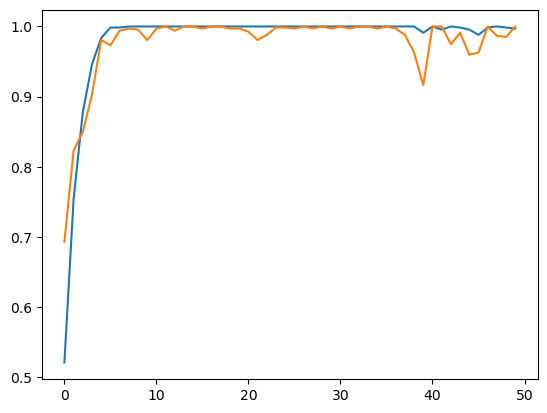

In [ ]:
train_net(emo_net, e_optimizer, e_criterion, train_loader_e, val_loader_e, 50)

In [ ]:
eval_net(emo_net, test_loader_e)

Test acc: 1.0000000000
